# 1. Linear Regression and Logistic Regression

This tutorial shows how to apply linear regression and logistic regression using PyTorch. 

In [1]:
import numpy as np
import pandas as pd

# visualization libraries
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# pytorch dependencies
import torch
from torch.autograd import Variable
# import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


## 1.1 Linear Regression

### Problem setting
- Given: given is a set of measurement pairs $\left\{x^{(i)}, y^{\text {(i)}}\right\}_{i=1,...m}$ with $x \in \mathbb{R}^{n}$ and $y \in \mathbb{R}$
- Question:  if a give you a novel $x$, what would be your best guess about its corresponding $y$?
- Linear regression assumption: 

 $$y \approx h(x)=\vartheta^{\top} x = \vartheta_0 + \vartheta_1 \cdot x_1 + ... \vartheta_n \cdot x_n$$

> Note: $\vartheta_0$ is the so called bias term and you can read more about it in the "Analytical Solution" subsection below.

<br>

 In matrix form this becomes:
 $$Y \approx X \vartheta$$

 <br> 

 As a reminder, we can interpret the linear dependence assumption as a Maximum Likelihood Estimation of the "true" underlying linear dependence between inputs $x$ and outputs $y$ with added Gaussian noise on top:

 $$Y = X \vartheta + \epsilon, \quad \text{with} \; \epsilon \sim \mathcal{N}(0,\sigma^2), \; \epsilon \in \mathbb{R}^n$$

### 1.1.1 Artificial Dataset

In [2]:
a = 3
b = 2
x = np.random.rand(256)

noise = np.random.randn(256) / 4

y = a + b*x + noise


For convenience, we use Pandas to store our values in the dataframe and then access them out of the dataframe - this is a highly common workflow for machine learning datasets. A normal split would be a Pandas dataframe for labels, serial data etc. and images in the same folder, which can then be described with the PyTorch DataSet API.

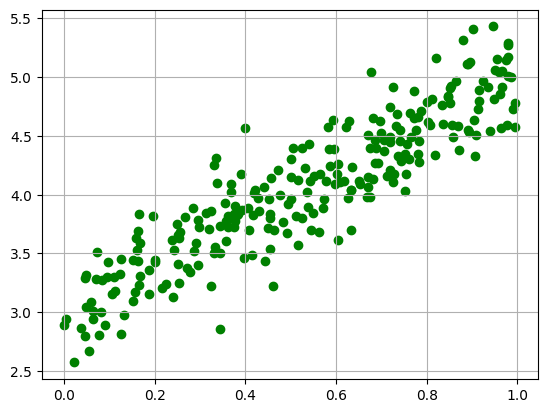

In [3]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y

plt.scatter(df['x'], df['y'], color='green')
plt.grid()
plt.show()


### 1.1.2 Gradient Descent Optimization

In the lecture we saw that for an iterative optimization process, e.g. gradient descent, we need to define a measure $J$, which capture the error. This quantity is what we essentially minimize through repeated updates of the parameters $\vartheta$. One very common **error function** $J$, a.k.a. **loss** or as PyTorch calls it **criterion**, is the mean squared error (MSE), a.k.a. squared L2 loss:

$$J(\vartheta)=\frac{1}{2} \sum_{i=1}^{m}\left(h\left(x^{(i)}\right)-y^{(i)}\right)^{2}$$

In [4]:
# Reshape the input variables
x_train = x.reshape(-1, 1).astype('float32')
y_train = y.reshape(-1, 1).astype('float32')

# Definition of the linear regression model


class LinearRegressionModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

learning_rate = 0.01
epochs = 100

model = LinearRegressionModel(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


Test the performance of the model ** before ** we do any optimization: 


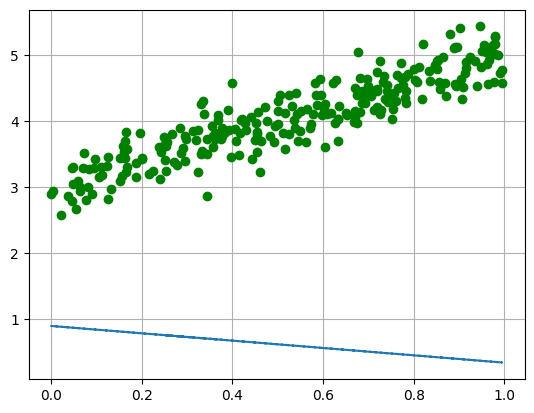

In [5]:
print("Test the performance of the model ** before ** we do any optimization: ")

with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data')
plt.plot(x_train, predicted, '--', label='Predictions')
plt.grid()
plt.show()


The model is currently initialized with some random numbers. These are:

In [6]:
for name, param in model.named_parameters():
  print(name, ": ", param.data)
  # bias = \vartheta_0
  # weight = \vartheta_1:n


linear.weight :  tensor([[-0.5554]])
linear.bias :  tensor([0.9009])


In [7]:
for epoch in range(epochs):

    inputs = Variable(torch.from_numpy(x_train))
    y_train_var = Variable(torch.from_numpy(y_train))

    # Clear gradient buffer
    optimizer.zero_grad()

    # Output from model given the inputs
    y_pred = model(inputs)

    # Get loss for the model's prediction
    loss = criterion(y_pred, y_train_var)
    loss.backward()

    # Update the model's parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))


epoch 0, loss 12.534360885620117
epoch 1, loss 11.89834213256836
epoch 2, loss 11.294977188110352
epoch 3, loss 10.722587585449219
epoch 4, loss 10.179581642150879
epoch 5, loss 9.664450645446777
epoch 6, loss 9.175765037536621
epoch 7, loss 8.712163925170898
epoch 8, loss 8.272361755371094
epoch 9, loss 7.855134010314941
epoch 10, loss 7.459324359893799
epoch 11, loss 7.083829879760742
epoch 12, loss 6.727608680725098
epoch 13, loss 6.389671325683594
epoch 14, loss 6.069077968597412
epoch 15, loss 5.764939308166504
epoch 16, loss 5.476409435272217
epoch 17, loss 5.202686786651611
epoch 18, loss 4.943011283874512
epoch 19, loss 4.696661949157715
epoch 20, loss 4.462953567504883
epoch 21, loss 4.241237163543701
epoch 22, loss 4.03089714050293
epoch 23, loss 3.8313491344451904
epoch 24, loss 3.6420397758483887
epoch 25, loss 3.46244215965271
epoch 26, loss 3.292058229446411
epoch 27, loss 3.1304149627685547
epoch 28, loss 2.9770634174346924
epoch 29, loss 2.8315775394439697
epoch 30, los

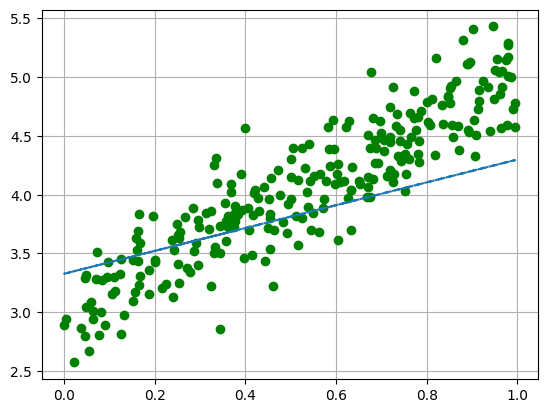

linear.weight :  tensor([[0.9721]])
linear.bias :  tensor([3.3274])


In [8]:
with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data')
plt.plot(x_train, predicted, '--', label='Predictions')
plt.grid()
plt.show()

for name, param in model.named_parameters():
  print(name, ": ", param.data)


### 1.1.3 Stochastic Gradient Descent

We can run the same optimization, but on chunks of the data, a.k.a. minibatches. This variant of gradient descent is then called Stochastic Gradient Descent due to the stochastic nature of optimizing $\vartheta$ on subsets of the data.

In [9]:
batch_size = 32
num_batches = len(x) // batch_size
batch_idxs = np.arange(num_batches)

for epoch in range(epochs):
    np.random.shuffle(batch_idxs)

    for i in batch_idxs:
        # slice out the portion of x and y, which corresponds to the batch i
        x_batch = x_train[batch_size*i:batch_size*(i+1)]
        y_batch = y_train[batch_size*i:batch_size*(i+1)]

        inputs = Variable(torch.from_numpy(x_batch))
        y_train_var = Variable(torch.from_numpy(y_batch))

        # Clear gradient buffer
        optimizer.zero_grad()

        # Output from model given the inputs
        y_pred = model(inputs)

        # Get loss for the model's prediction
        loss = criterion(y_pred, y_train_var)
        loss.backward()

        # Update the model's parameters
        optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))


epoch 0, loss 0.24362248182296753
epoch 1, loss 0.14591069519519806
epoch 2, loss 0.13684681057929993
epoch 3, loss 0.13316473364830017
epoch 4, loss 0.1839783638715744
epoch 5, loss 0.17501355707645416
epoch 6, loss 0.09760620445013046
epoch 7, loss 0.16902786493301392
epoch 8, loss 0.12351018935441971
epoch 9, loss 0.17205482721328735
epoch 10, loss 0.1712622344493866
epoch 11, loss 0.085511714220047
epoch 12, loss 0.1379004567861557
epoch 13, loss 0.136119544506073
epoch 14, loss 0.1133987084031105
epoch 15, loss 0.08040167391300201
epoch 16, loss 0.1317214071750641
epoch 17, loss 0.11957771331071854
epoch 18, loss 0.07753628492355347
epoch 19, loss 0.14753416180610657
epoch 20, loss 0.10848265886306763
epoch 21, loss 0.10766678303480148
epoch 22, loss 0.11518580466508865
epoch 23, loss 0.14333446323871613
epoch 24, loss 0.07293468713760376
epoch 25, loss 0.10457058995962143
epoch 26, loss 0.07159407436847687
epoch 27, loss 0.09635239839553833
epoch 28, loss 0.15139631927013397
epoc

Test the performance of the model **after** optimization:

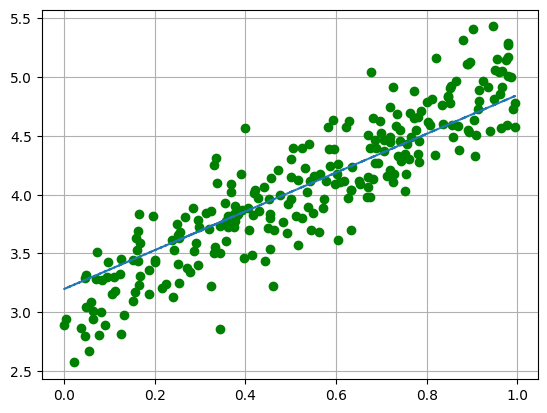

linear.weight :  tensor([[1.6509]])
linear.bias :  tensor([3.1976])


In [10]:
with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data')
plt.plot(x_train, predicted, '--', label='Predictions')
plt.grid()
plt.show()

for name, param in model.named_parameters():
  print(name, ": ", param.data)


### 1.1.4 Analytical Solution

As we saw in the lecture, the linear regression problem is one of the very few machine learning algorithms which admits an analytical solution. This reads

$$
\quad\vartheta=\left(X^{\top}X\right)^{-1}X^{\top}Y
$$

> Caution: To get the so called bias term $\vartheta_0$, we need to extend $X$ to 

$$X_{m \times n}=\left[\begin{array}{c}x^{(1) \top }\\ \vdots \\ x^{(m) \top} \\ \mathbf{1}^{\top}\end{array}\right],$$

otherwise we assume that the line we are fitting crosses $y$ at $x=0$. The PyTorch model we saw before automatically defines a bias term and optimizes it to the data.

In [11]:
# extended x vector
x_ext = np.ones((x.shape[0], 2))
x_ext[:,0] = x

xtx = x_ext.T.dot(x_ext)
xtx_inv = np.linalg.inv(xtx)
xtx_inv_xt = xtx_inv.dot(x_ext.T)
theta = xtx_inv_xt.dot(y)

print("theta =", theta)

theta = [2.00647914 2.99636588]


### 1.1.5 Exercise

Apply linear regression on the housing price dataset provided [here](https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction) using:
1. Gradien Descent
2. Stochastic Gradient Descent
3. Analytical Solution

> Note: there won't be a solution to this exercise. It is only provided as practice material.

> Hint: You might find [this](https://www.kaggle.com/code/aminizahra/linear-regression) helpful.

In [12]:
####################
# TODO


####################

## 1.2 Logistic Regression

### Problem setting

- Given: given is a set of measurement pairs $\left\{x^{(i)}, y^{\text {(i)}}\right\}_{i=1,...m}$ with $x \in \mathbb{R}^{n}$ and $y \in \{0,1\}$
- Question:  if a give you a novel $x$, what would be your best guess about its corresponding $y$? Up until here, the only difference to linear regression is in the domain of $y$.
- Logistic regression assumption: Instead of asking directly whether the class is 0 or 1, we model the ***probability of the class being 1*** with $h$:
 $$h(x) = \varphi \left( \vartheta^{\top} x \right) = \frac{1}{1+e^{-\vartheta^{\top} x}} = \frac{1}{1+e^{-(\vartheta_0 + \vartheta_1 \cdot x_1 ... + \vartheta_n \cdot x_n)}} $$

Sigmoid function:

<div style="text-align:center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png" alt="drawing" width="400"/>
</div>


 > Note: Unfortunately, even this very simple classification model does not have an analytical solution, thus we use gradient-based optimization.

 Reference: this implementation is a simplification of the example given [here](https://blog.jovian.ai/torch-logistic-regression-on-iris-dataset-d966b23339da).

### 1.2.1 Iris Dataset

In [13]:
# get iris dataset
from urllib.request import urlretrieve
iris = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urlretrieve(iris)
df0 = pd.read_csv(iris, sep=',')

# name columns
attributes = ["sepal_length", "sepal_width",
              "petal_length", "petal_width", "class"]
df0.columns = attributes

# add species index
species = list(df0["class"].unique())
df0["class_idx"] = df0["class"].apply(species.index)

print(df0.head())
print("Count occurence of each class:")
print(df0["class"].value_counts())


   sepal_length  sepal_width  petal_length  petal_width        class  \
0           4.9          3.0           1.4          0.2  Iris-setosa   
1           4.7          3.2           1.3          0.2  Iris-setosa   
2           4.6          3.1           1.5          0.2  Iris-setosa   
3           5.0          3.6           1.4          0.2  Iris-setosa   
4           5.4          3.9           1.7          0.4  Iris-setosa   

   class_idx  
0          0  
1          0  
2          0  
3          0  
4          0  
Count occurence of each class:
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        49
Name: class, dtype: int64


Your can learn more about this well established dataset [here](https://archive.ics.uci.edu/ml/datasets/Iris). In essence, we see measurements of 4 different features and the corresponding type of iris plant out of ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']. We transform this problem to a logistic regression problem by looking only at two of the classes, which we denote with [0,1]. In addition, we consider only two of the features to make visualization possible.

In [14]:
df = df0[["petal_length", "petal_width", "class_idx"]]
df = df[df["class_idx"] != 0]
df["class_idx"] = df["class_idx"] - 1

print(df["class_idx"].value_counts())
print(df)

0    50
1    50
Name: class_idx, dtype: int64
     petal_length  petal_width  class_idx
49            4.7          1.4          0
50            4.5          1.5          0
51            4.9          1.5          0
52            4.0          1.3          0
53            4.6          1.5          0
..            ...          ...        ...
144           5.2          2.3          1
145           5.0          1.9          1
146           5.2          2.0          1
147           5.4          2.3          1
148           5.1          1.8          1

[100 rows x 3 columns]


In [15]:
fig = px.scatter_3d(df[["petal_length", "petal_width", "class_idx"]],
                    x='petal_length',
                    y='petal_width',
                    z='class_idx',
                    color='class_idx',
                    opacity=0.9)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

### 1.2.2 Preprocess and Dataloader

In [16]:
input_columns = torch.from_numpy(
    df[['petal_length', 'petal_width']].to_numpy()).type(torch.float32)
output_columns = torch.from_numpy(
    df['class_idx'].to_numpy()).type(torch.float32)
output_columns = output_columns.reshape(-1, 1)

print("Input columns: ", input_columns.shape, input_columns.dtype)
print("Output columns: ", output_columns.shape, output_columns.dtype)


Input columns:  torch.Size([100, 2]) torch.float32
Output columns:  torch.Size([100, 1]) torch.float32


In [17]:
# set hyperparameters
batch_size = 25

# create a PyTorch data object used by DataLoader
data = TensorDataset(input_columns, output_columns)

# define data loader which shuffles the data
train_loader = DataLoader(data, batch_size, shuffle=True)

# one batch of training data would look like this:
for x in train_loader:
    print(x, x[0].shape, x[0].dtype)
    break


[tensor([[4.5000, 1.5000],
        [4.5000, 1.6000],
        [5.4000, 2.3000],
        [6.3000, 1.8000],
        [3.0000, 1.1000],
        [4.0000, 1.2000],
        [4.7000, 1.6000],
        [4.5000, 1.5000],
        [4.9000, 1.8000],
        [4.8000, 1.8000],
        [4.5000, 1.3000],
        [5.1000, 1.9000],
        [6.1000, 2.3000],
        [5.5000, 2.1000],
        [4.4000, 1.2000],
        [6.7000, 2.0000],
        [3.9000, 1.1000],
        [4.2000, 1.2000],
        [5.9000, 2.1000],
        [5.8000, 2.2000],
        [5.6000, 1.8000],
        [4.3000, 1.3000],
        [4.0000, 1.3000],
        [4.9000, 1.5000],
        [4.9000, 2.0000]]), tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.

### 1.2.3 Model and Training

In [18]:
# This is the core part of the logistic regression. Here we define the linear
# transformation of x and afterwards pushing it through sigmoid

# Define model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear1(x))
        return outputs


The [`torch.nn.BCELoss(h(x),y)`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) function implements $-\log p(y|x;\vartheta) = - \log \left(h^y(x)(1-h(x))^{1-y}\right)$. Maximizing the probability is the same as minimizing this loss.

In [19]:
# set hyperparameters
learning_rate = 1.0
epochs = 500

input_dim = 2
output_dim = 1

# instantiating the model
model = LogisticRegression(input_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
for epoch in range(epochs):
    for x, y in train_loader:

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    print("Epoch: {}. Loss: {}.".format(epoch + 1, loss.item()))

Epoch: 1. Loss: 1.150997281074524.
Epoch: 2. Loss: 1.385910987854004.
Epoch: 3. Loss: 1.4735668897628784.
Epoch: 4. Loss: 4.336208343505859.
Epoch: 5. Loss: 3.120725154876709.
Epoch: 6. Loss: 1.035387396812439.
Epoch: 7. Loss: 1.8818854093551636.
Epoch: 8. Loss: 3.112588405609131.
Epoch: 9. Loss: 5.0494866371154785.
Epoch: 10. Loss: 3.743957757949829.
Epoch: 11. Loss: 4.106730937957764.
Epoch: 12. Loss: 3.9786674976348877.
Epoch: 13. Loss: 1.8222899436950684.
Epoch: 14. Loss: 2.072605848312378.
Epoch: 15. Loss: 6.539145469665527.
Epoch: 16. Loss: 6.2265214920043945.
Epoch: 17. Loss: 3.0322659015655518.
Epoch: 18. Loss: 5.5355305671691895.
Epoch: 19. Loss: 2.9194400310516357.
Epoch: 20. Loss: 4.631555557250977.
Epoch: 21. Loss: 0.8201667666435242.
Epoch: 22. Loss: 1.1318951845169067.
Epoch: 23. Loss: 0.6846733093261719.
Epoch: 24. Loss: 3.4803314208984375.
Epoch: 25. Loss: 1.513106107711792.
Epoch: 26. Loss: 2.07596492767334.
Epoch: 27. Loss: 0.7559216022491455.
Epoch: 28. Loss: 3.42897

In [21]:
for name, param in model.named_parameters():
  print(name, ": ", param.data)
# theta_0 = bias, theta_1:2 = weight

# Interpretation:
# linear1.weight :  tensor([[3.4394, 8.9426]])
# -> both parameters are positively correlated, i.e. if any of them increase,
# the probability of having class "1" increases
# linear1.bias :  tensor([-31.8393])
# -> offset prediction by -31.8, which conteracts the large positive weights


linear1.weight :  tensor([[2.2820, 8.6936]])
linear1.bias :  tensor([-26.3593])


In [22]:
x = np.linspace(input_columns[:,0].min(), input_columns[:,0].max(), 10)
y = np.linspace(input_columns[:,1].min(), input_columns[:,1].max(), 10)
xx, yy = np.meshgrid(x,y)
X, Y = xx.flatten(), yy.flatten()
XY = np.vstack([X,Y]).T

with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(XY).type(torch.float32))).data.numpy()

predicted = predicted.squeeze()
predicted = predicted.reshape(10,10)

In [23]:
fig = go.Figure(data=[
    go.Surface(
        contours={
            "z": {"show": True, "start": 0.5, "end": 0.5001, "size": 0.05}
        },
        x=x,
        y=y,
        z=predicted,
        opacity=0.5
    ),
    go.Scatter3d(
        x=df["petal_length"],
        y=df['petal_width'],
        z=df['class_idx'],
        mode='markers',
        marker=dict(
            color=df['class_idx'],
            opacity=0.99,
        )
    )
])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  scene={
                      "camera_eye": {"x": 7, "y": -3., "z": 0.5},
                      "aspectratio": {"x": 8, "y": 3, "z": 2}
}
)
fig.show()


### 1.2.4 Exercise

Apply logistic regression to the [MNIST handwritten digits](http://yann.lecun.com/exdb/mnist/) dataset. Main differences to the Iris dataset:
- the inputs are images of shape [28,28,1] and need to be flattened out
- the output here is not the probability of being in one class (as in the problem we discusses here), but 10 classes and the probability of being in each of them.

> Hint: You might find help [here](https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19).

In [24]:
####################
# TODO


####################